In [5]:
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

print("Torch version:", torch.__version__)
print(clip.available_models())

clip.available_models()

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
_, preprocess = clip.load("RN101",device=device,jit=False) #Must set jit=False for training
#ViT-L/14@336px


# CSV 파일을 DataFrame으로 로드합니다.
df = pd.read_csv("train.csv")
df = df[df['caption'].apply(lambda x: len(x.split()) <= 74)] # 74어절 이상은 제거
# DataFrame의 전체 길이
total_len = len(df)

# 각 부분의 길이를 계산합니다.
train_len = int(total_len * 0.7)  # 학습 데이터는 전체 데이터의 70%
val_len = int(total_len * 0.15)   # 검증 데이터는 전체 데이터의 15%

# 학습, 검증, 테스트 데이터 세트를 분할합니다.
train_df = df.iloc[:train_len]
val_df = df.iloc[train_len:train_len + val_len]
test_df = df.iloc[train_len + val_len:]

# 결과 확인
print(f"Total: {total_len}, Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

BATCH_SIZE = 32
EPOCH = 50

Torch version: 2.0.1
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Total: 158912, Train: 111238, Validation: 23836, Test: 23838


In [9]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
class image_caption_dataset(Dataset):
    def __init__(self, df):

        self.images = df["image"].tolist()
        self.caption = df["caption"].tolist()
    def __len__(self):
        return len(self.caption)

    def __getitem__(self, idx):

        images = preprocess(Image.open("./images/flickr30k_images/"+self.images[idx])) #preprocess from clip.load
        caption =  self.caption[idx]
        return images,caption

Train_df = image_caption_dataset(train_df)
Val_df = image_caption_dataset(val_df)

train_dataloader = DataLoader(Train_df, batch_size = BATCH_SIZE, shuffle = True) #Define your own dataloader
valid_dataloader = DataLoader(Val_df, batch_size = BATCH_SIZE, shuffle = True) #Define your own dataloader

In [10]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import timm

class Image_Encoder(nn.Module):
    def __init__(self):
        super(Image_Encoder, self).__init__()
        self.base_model = timm.create_model('resnet101', pretrained=True, num_classes=256)
        self.fc1 = nn.Linear(256, 128)
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        return x

class Text_Encoder(nn.Module):
    def __init__(self):
        super(Text_Encoder, self).__init__()
        self.base_model = GPT2Model.from_pretrained('gpt2')
        self.fc1 = nn.Linear(768, 128)

    def forward(self, input_ids, attention_mask):
        # 디바이스 할당이 필요한 경우, 여기서 input_ids와 attention_mask를 디바이스로 이동
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]  # 첫 번째 토큰의 임베딩 사용, 전체 배치에 대해
        x = self.fc1(x)
        return x  # 128차원의 출력 벡터


class Clip_Encoder(nn.Module):
    def __init__(self):
        super(Clip_Encoder, self).__init__()
        self.img_feature = Image_Encoder()
        self.text_feature = Text_Encoder()
        
    def forward(self, img, input_ids, attention_mask):
        img_feature = self.img_feature(img)
        text_feature = self.text_feature(input_ids, attention_mask)

        I_e = F.normalize(img_feature, p=2, dim=1)
        T_e = F.normalize(text_feature, p=2, dim=1)
        logits = torch.matmul(I_e, T_e.T) * torch.exp(torch.tensor(1))

        return logits  #img_feature, text_feature # 128 shape

In [11]:
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

model = Clip_Encoder()
model.to(device)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001, weight_decay = 0.0005)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

valid_loss_min = np.Inf

# add your own code to track the training progress.
for epoch in range(EPOCH):
  total_loss_epoch = 0.0
  total_acc_img_epoch = 0.0
  total_acc_txt_epoch = 0.0
  total_val_loss = 0.0
  total_val_acc = 0.0
  train_preds = []
  train_targets = []

  total_train_correct = 0  # 정확하게 예측된 총 샘플 수
  total_train_samples = 0  # 데이터셋의 총 샘플 수
  # for batch in train_dataloader :
  model.train()
  for images, texts in tqdm(train_dataloader):
      optimizer.zero_grad()



      # images,texts = batch
      images= images.to(device)
      texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
      input_ids = texts['input_ids'].to(device)
      attention_mask = texts['attention_mask'].to(device)

      ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

      logit = model(images,input_ids,attention_mask)
      total_loss = (loss_img(logit,ground_truth) + loss_txt(logit.T,ground_truth))/2
      total_loss_epoch += total_loss.item()
      total_loss.backward()
      optimizer.step()

      _, predicted = logit.max(1)
      total_train_correct += (predicted == ground_truth).sum().item()
      total_train_samples += ground_truth.size(0)
      train_preds.extend(predicted.cpu().numpy())
      train_targets.extend(ground_truth.cpu().numpy())

  avg_train_loss = total_loss_epoch / len(train_dataloader)
  avg_train_acc_img = total_train_correct / total_train_samples  # 평균 정확도 계산     

  ######################    
  # validate the model #
  ######################
  valid_preds = []
  valid_targets = []

  total_val_correct = 0  # 정확하게 예측된 총 샘플 수
  total_val_samples = 0  # 검증 데이터셋의 총 샘플 수
  with torch.no_grad(): 
    model.eval()  # 모델을 평가 모드로 설정

    for images, texts in tqdm(valid_dataloader):
        # images, texts = batch
        images= images.to(device)
        texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        input_ids = texts['input_ids'].to(device)
        attention_mask = texts['attention_mask'].to(device)
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

        logit = model(images,input_ids,attention_mask)
        total_loss = (loss_img(logit,ground_truth) + loss_txt(logit.T,ground_truth))/2
        total_val_loss += total_loss.item()
        _, predicted = logit.max(1)
        total_val_correct += (predicted == ground_truth).sum().item()
        total_val_samples += ground_truth.size(0)
        valid_preds.extend(predicted.cpu().numpy())
        valid_targets.extend(ground_truth.cpu().numpy())

    avg_val_loss = total_val_loss / len(valid_dataloader)
    avg_val_acc = total_val_correct / total_val_samples  # 평균 정확도 계산     
    cm = confusion_matrix(valid_targets, valid_preds)
    print(f"Confusion Matrix for Validation at Epoch {epoch + 1}:\n{cm}")
 # epoch 결과 출력
  print(f"Epoch {epoch + 1}/{EPOCH}") 
  print(f"Train Loss: {avg_train_loss:.4f}, Train Image Accuracy: {avg_train_acc_img:.4f}")
  print(f"Validation Loss: {avg_val_loss:.4f}, Validation Image Accuracy: {avg_val_acc:.4f}")

 # 검증 손실이 이전 최저 손실보다 낮으면 모델 저장
  if avg_val_loss < valid_loss_min:
      valid_loss_min = avg_val_loss 
      print('=====================================================================')
      print(f"New best model found at epoch {epoch + 1} with Validation Loss: {avg_val_loss:.4f}. Saving model.")
      torch.save(model.state_dict(), 'clip_model.pt')

   


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Confusion Matrix for Validation at Epoch 1:
[[18  6  5 ...  2  1  2]
 [12  5  6 ...  0  1  1]
 [ 6  7 10 ...  1  1  0]
 ...
 [11  5  5 ...  0  2  1]
 [19  4  4 ...  0  2  1]
 [14  4  3 ...  0  1  3]]
Epoch 1/50
Train Loss: 3.4666, Train Image Accuracy: 0.0328
Validation Loss: 3.4542, Validation Image Accuracy: 0.0405
New best model found at epoch 1 with Validation Loss: 3.4542. Saving model.


100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


Confusion Matrix for Validation at Epoch 2:
[[1 5 1 ... 0 0 3]
 [1 6 3 ... 3 1 2]
 [0 4 0 ... 0 1 0]
 ...
 [2 3 4 ... 3 1 2]
 [2 1 1 ... 3 0 4]
 [0 3 3 ... 0 1 2]]
Epoch 2/50
Train Loss: 3.4109, Train Image Accuracy: 0.0462
Validation Loss: 3.4588, Validation Image Accuracy: 0.0445


100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


Confusion Matrix for Validation at Epoch 3:
[[7 4 2 ... 0 3 2]
 [6 7 3 ... 1 1 1]
 [2 3 6 ... 5 2 3]
 ...
 [6 1 1 ... 1 4 2]
 [3 6 0 ... 0 3 4]
 [4 6 3 ... 2 3 2]]
Epoch 3/50
Train Loss: 3.2596, Train Image Accuracy: 0.0655
Validation Loss: 3.4588, Validation Image Accuracy: 0.0570


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Confusion Matrix for Validation at Epoch 4:
[[7 1 4 ... 1 1 0]
 [8 8 1 ... 2 3 1]
 [3 4 4 ... 1 1 0]
 ...
 [6 2 2 ... 4 2 1]
 [4 1 3 ... 1 2 3]
 [6 4 2 ... 0 0 2]]
Epoch 4/50
Train Loss: 3.1723, Train Image Accuracy: 0.0829
Validation Loss: 3.4653, Validation Image Accuracy: 0.0590


100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


Confusion Matrix for Validation at Epoch 5:
[[2 1 5 ... 1 1 0]
 [5 4 4 ... 1 1 3]
 [3 6 6 ... 5 1 2]
 ...
 [6 1 2 ... 1 1 0]
 [6 4 3 ... 2 2 1]
 [2 4 3 ... 4 3 3]]
Epoch 5/50
Train Loss: 3.1265, Train Image Accuracy: 0.0944
Validation Loss: 3.4372, Validation Image Accuracy: 0.0525
New best model found at epoch 5 with Validation Loss: 3.4372. Saving model.


100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


Confusion Matrix for Validation at Epoch 6:
[[5 2 2 ... 1 2 3]
 [3 5 4 ... 0 1 3]
 [3 3 5 ... 0 0 2]
 ...
 [3 1 3 ... 1 0 3]
 [3 3 1 ... 0 1 4]
 [1 5 3 ... 0 3 5]]
Epoch 6/50
Train Loss: 3.0874, Train Image Accuracy: 0.0951
Validation Loss: 3.4992, Validation Image Accuracy: 0.0545


100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Confusion Matrix for Validation at Epoch 7:
[[6 2 3 ... 0 1 1]
 [6 7 2 ... 0 1 0]
 [7 3 2 ... 1 1 2]
 ...
 [5 6 2 ... 1 0 1]
 [7 2 4 ... 0 0 0]
 [7 7 1 ... 1 0 2]]
Epoch 7/50
Train Loss: 3.0721, Train Image Accuracy: 0.1037
Validation Loss: 3.4899, Validation Image Accuracy: 0.0485


100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


Confusion Matrix for Validation at Epoch 8:
[[4 6 3 ... 1 0 3]
 [5 3 1 ... 1 1 2]
 [7 4 5 ... 1 2 2]
 ...
 [5 3 4 ... 2 1 2]
 [1 2 2 ... 0 5 1]
 [5 6 2 ... 2 1 2]]
Epoch 8/50
Train Loss: 3.0502, Train Image Accuracy: 0.1165
Validation Loss: 3.5030, Validation Image Accuracy: 0.0605


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Confusion Matrix for Validation at Epoch 9:
[[ 9  3  2 ...  0  3  1]
 [ 4  7  5 ...  2  2  0]
 [ 6  3  4 ...  2  3  0]
 ...
 [10  1  0 ...  3  2  1]
 [ 7  2  1 ...  1  3  2]
 [ 8  4  1 ...  2  1  4]]
Epoch 9/50
Train Loss: 3.0225, Train Image Accuracy: 0.1141
Validation Loss: 3.4876, Validation Image Accuracy: 0.0540


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Confusion Matrix for Validation at Epoch 10:
[[6 3 2 ... 0 2 1]
 [6 5 2 ... 0 1 0]
 [4 5 7 ... 0 2 1]
 ...
 [6 5 1 ... 2 1 0]
 [5 4 3 ... 2 2 0]
 [3 3 0 ... 1 0 3]]
Epoch 10/50
Train Loss: 3.0084, Train Image Accuracy: 0.1184
Validation Loss: 3.5757, Validation Image Accuracy: 0.0490


100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


Confusion Matrix for Validation at Epoch 11:
[[ 9  2  2 ...  2  1  2]
 [ 6  4  4 ...  2  0  2]
 [ 6  4  7 ...  2  0  0]
 ...
 [10  4  2 ...  1  0  0]
 [ 7  6  8 ...  0  1  2]
 [ 4  2  3 ...  1  0  3]]
Epoch 11/50
Train Loss: 2.9949, Train Image Accuracy: 0.1314
Validation Loss: 3.5079, Validation Image Accuracy: 0.0465


100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Confusion Matrix for Validation at Epoch 12:
[[10  3  3 ...  3  1  0]
 [ 5  7  2 ...  1  1  1]
 [ 2  5  9 ...  2  0  2]
 ...
 [ 9  5  6 ...  0  0  1]
 [ 6  3  0 ...  0  6  1]
 [ 7  3  5 ...  0  4  4]]
Epoch 12/50
Train Loss: 2.9788, Train Image Accuracy: 0.1371
Validation Loss: 3.5391, Validation Image Accuracy: 0.0570


100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


Confusion Matrix for Validation at Epoch 13:
[[10  6  6 ...  1  2  0]
 [ 3  8  5 ...  3  1  1]
 [ 6  6  2 ...  1  1  0]
 ...
 [ 8  2  4 ...  5  3  1]
 [ 5  8  5 ...  2  3  2]
 [10  5  7 ...  2  0  2]]
Epoch 13/50
Train Loss: 2.9590, Train Image Accuracy: 0.1406
Validation Loss: 3.5233, Validation Image Accuracy: 0.0520


100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


Confusion Matrix for Validation at Epoch 14:
[[ 3  5  3 ...  0  3  6]
 [ 6  8  4 ...  1  2  0]
 [ 3  8  7 ...  0  2  0]
 ...
 [10  6  4 ...  1  2  1]
 [ 6  5  7 ...  0  0  2]
 [ 2  5  5 ...  1  3  5]]
Epoch 14/50
Train Loss: 2.9541, Train Image Accuracy: 0.1492
Validation Loss: 3.5460, Validation Image Accuracy: 0.0570


100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Confusion Matrix for Validation at Epoch 15:
[[6 5 1 ... 0 2 0]
 [2 6 0 ... 1 2 1]
 [3 6 4 ... 1 2 0]
 ...
 [4 2 2 ... 2 1 2]
 [3 6 3 ... 1 5 1]
 [6 3 2 ... 1 1 3]]
Epoch 15/50
Train Loss: 2.9448, Train Image Accuracy: 0.1497
Validation Loss: 3.5381, Validation Image Accuracy: 0.0655


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 16:
[[8 5 3 ... 3 5 2]
 [5 2 5 ... 0 0 2]
 [9 4 7 ... 0 0 3]
 ...
 [3 7 0 ... 4 0 2]
 [5 7 3 ... 4 3 0]
 [3 4 3 ... 0 1 1]]
Epoch 16/50
Train Loss: 2.9467, Train Image Accuracy: 0.1545
Validation Loss: 3.5695, Validation Image Accuracy: 0.0525


100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Confusion Matrix for Validation at Epoch 17:
[[6 4 1 ... 1 5 0]
 [3 6 0 ... 2 1 2]
 [3 5 7 ... 1 2 1]
 ...
 [5 7 1 ... 3 1 1]
 [7 3 2 ... 3 3 2]
 [1 3 2 ... 1 2 4]]
Epoch 17/50
Train Loss: 2.9293, Train Image Accuracy: 0.1559
Validation Loss: 3.5547, Validation Image Accuracy: 0.0515


100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Confusion Matrix for Validation at Epoch 18:
[[12  3  3 ...  2  2  0]
 [ 7 12  1 ...  2  1  2]
 [10  5  5 ...  0  2  3]
 ...
 [ 8  4  3 ...  6  2  1]
 [ 6  4  7 ...  1  3  1]
 [ 7  6  5 ...  2  0  2]]
Epoch 18/50
Train Loss: 2.9268, Train Image Accuracy: 0.1613
Validation Loss: 3.5376, Validation Image Accuracy: 0.0600


100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


Confusion Matrix for Validation at Epoch 19:
[[11  5  1 ...  2  2  1]
 [ 9  5  4 ...  1  2  3]
 [ 5  1  6 ...  4  1  2]
 ...
 [ 7  4  3 ...  0  1  3]
 [10  2  2 ...  0  2  2]
 [10  4  5 ...  2  0  3]]
Epoch 19/50
Train Loss: 2.9199, Train Image Accuracy: 0.1600
Validation Loss: 3.5280, Validation Image Accuracy: 0.0615


100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


Confusion Matrix for Validation at Epoch 20:
[[12  2  4 ...  0  1  1]
 [11  9  2 ...  0  2  2]
 [ 8  4  4 ...  0  0  3]
 ...
 [ 8  4  1 ...  1  1  1]
 [15  6  2 ...  0  2  0]
 [ 9  2  1 ...  0  0  3]]
Epoch 20/50
Train Loss: 2.9157, Train Image Accuracy: 0.1643
Validation Loss: 3.5209, Validation Image Accuracy: 0.0600


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 21:
[[ 8  4  5 ...  1  0  3]
 [ 4  9  0 ...  2  1  5]
 [ 6 10  1 ...  2  0  4]
 ...
 [ 3  2  4 ...  6  0  0]
 [ 5  2  3 ...  1  1  2]
 [ 5  5  4 ...  1  2  3]]
Epoch 21/50
Train Loss: 2.9118, Train Image Accuracy: 0.1639
Validation Loss: 3.5761, Validation Image Accuracy: 0.0540


100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


Confusion Matrix for Validation at Epoch 22:
[[8 2 0 ... 2 2 1]
 [9 3 2 ... 2 1 1]
 [9 5 5 ... 0 0 0]
 ...
 [5 1 5 ... 0 2 1]
 [6 5 6 ... 0 3 0]
 [9 3 4 ... 0 2 1]]
Epoch 22/50
Train Loss: 2.9084, Train Image Accuracy: 0.1690
Validation Loss: 3.5421, Validation Image Accuracy: 0.0550


100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Confusion Matrix for Validation at Epoch 23:
[[7 4 4 ... 1 2 0]
 [8 6 2 ... 0 1 2]
 [3 5 3 ... 0 1 1]
 ...
 [4 2 8 ... 2 0 2]
 [7 2 5 ... 3 3 0]
 [2 6 4 ... 1 0 6]]
Epoch 23/50
Train Loss: 2.9086, Train Image Accuracy: 0.1709
Validation Loss: 3.5431, Validation Image Accuracy: 0.0590


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 24:
[[9 0 4 ... 3 0 3]
 [3 9 2 ... 0 0 3]
 [3 5 3 ... 1 1 2]
 ...
 [4 3 2 ... 3 1 2]
 [6 3 3 ... 2 1 4]
 [6 5 5 ... 0 1 6]]
Epoch 24/50
Train Loss: 2.9033, Train Image Accuracy: 0.1679
Validation Loss: 3.5736, Validation Image Accuracy: 0.0555


100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


Confusion Matrix for Validation at Epoch 25:
[[13  2  0 ...  0  2  2]
 [ 9  6  6 ...  0  1  1]
 [11  6  9 ...  0  1  0]
 ...
 [ 5  4  4 ...  5  0  2]
 [11  7  2 ...  2  4  1]
 [ 8  3  3 ...  1  1  2]]
Epoch 25/50
Train Loss: 2.9016, Train Image Accuracy: 0.1706
Validation Loss: 3.5740, Validation Image Accuracy: 0.0640


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 26:
[[7 3 6 ... 1 1 0]
 [3 7 3 ... 1 1 2]
 [7 4 7 ... 0 0 1]
 ...
 [6 3 5 ... 1 1 0]
 [6 5 2 ... 3 1 0]
 [3 7 2 ... 2 2 0]]
Epoch 26/50
Train Loss: 2.9035, Train Image Accuracy: 0.1724
Validation Loss: 3.5335, Validation Image Accuracy: 0.0540


100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


Confusion Matrix for Validation at Epoch 27:
[[9 0 5 ... 1 1 0]
 [5 3 4 ... 1 0 1]
 [8 5 8 ... 1 1 2]
 ...
 [8 4 4 ... 5 1 1]
 [4 4 5 ... 1 2 0]
 [7 6 6 ... 3 0 0]]
Epoch 27/50
Train Loss: 2.8961, Train Image Accuracy: 0.1736
Validation Loss: 3.5381, Validation Image Accuracy: 0.0515


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 28:
[[20  3  2 ...  0  1  1]
 [ 5  7  2 ...  1  2  1]
 [ 9  5  5 ...  1  0  1]
 ...
 [10  2  3 ...  4  0  1]
 [ 8  6  3 ...  1  1  3]
 [14  7  3 ...  0  2  5]]
Epoch 28/50
Train Loss: 2.8971, Train Image Accuracy: 0.1720
Validation Loss: 3.5602, Validation Image Accuracy: 0.0650


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 29:
[[8 5 2 ... 0 2 2]
 [6 7 1 ... 1 3 1]
 [8 5 3 ... 0 2 2]
 ...
 [6 4 3 ... 2 6 2]
 [1 7 2 ... 2 4 1]
 [5 3 5 ... 0 2 5]]
Epoch 29/50
Train Loss: 2.8913, Train Image Accuracy: 0.1756
Validation Loss: 3.5933, Validation Image Accuracy: 0.0545


100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Confusion Matrix for Validation at Epoch 30:
[[14  1  3 ...  1  2  0]
 [10  3  2 ...  0  0  2]
 [10  1  3 ...  0  0  1]
 ...
 [ 6  5  3 ...  3  0  2]
 [ 7  5  1 ...  1  2  0]
 [10  1  3 ...  1  2  2]]
Epoch 30/50
Train Loss: 2.8896, Train Image Accuracy: 0.1737
Validation Loss: 3.5689, Validation Image Accuracy: 0.0520


100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Confusion Matrix for Validation at Epoch 31:
[[10  4  2 ...  1  0  2]
 [ 4  4  4 ...  1  0  1]
 [ 5  5  4 ...  1  4  0]
 ...
 [ 4  3  2 ...  0  3  2]
 [ 4  2  3 ...  1  7  0]
 [ 4  3  2 ...  1  3  2]]
Epoch 31/50
Train Loss: 2.8889, Train Image Accuracy: 0.1791
Validation Loss: 3.5375, Validation Image Accuracy: 0.0560


100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


Confusion Matrix for Validation at Epoch 32:
[[11  2  4 ...  4  2  0]
 [ 9  9  2 ...  2  3  0]
 [ 8  4  6 ...  1  1  0]
 ...
 [ 6  2  3 ...  1  1  2]
 [ 8  8  5 ...  0  2  0]
 [ 5  6  6 ...  1  1  3]]
Epoch 32/50
Train Loss: 2.8864, Train Image Accuracy: 0.1729
Validation Loss: 3.5446, Validation Image Accuracy: 0.0550


100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


Confusion Matrix for Validation at Epoch 33:
[[11  6  0 ...  0  2  1]
 [ 6  5  1 ...  1  3  1]
 [13  7  3 ...  2  0  2]
 ...
 [12  7  4 ...  2  1  0]
 [11  4  2 ...  2  2  2]
 [10  3  1 ...  1  0  2]]
Epoch 33/50
Train Loss: 2.8862, Train Image Accuracy: 0.1816
Validation Loss: 3.5792, Validation Image Accuracy: 0.0490


100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Confusion Matrix for Validation at Epoch 34:
[[11  2  1 ...  3  1  1]
 [ 6  3  5 ...  0  1  1]
 [ 4  5  6 ...  1  0  0]
 ...
 [ 5  4  2 ...  2  1  1]
 [10  3  5 ...  1  4  1]
 [ 3  7  1 ...  1  3  2]]
Epoch 34/50
Train Loss: 2.8858, Train Image Accuracy: 0.1805
Validation Loss: 3.5256, Validation Image Accuracy: 0.0600


 42%|████▏     | 104/250 [01:14<01:44,  1.40it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


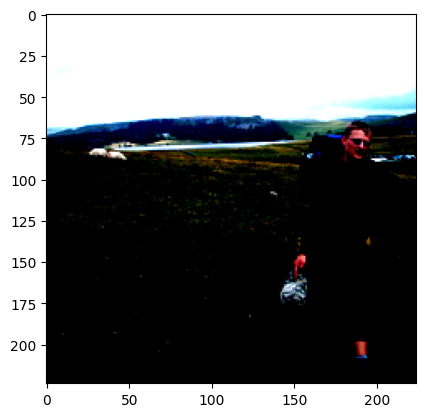

In [33]:
Test_df = image_caption_dataset(test_df)
test_dataloader = DataLoader(Train_df, batch_size = 4, shuffle = True) #Define your own dataloader
test_image, test_text= next(iter(test_dataloader))
plt.imshow(test_image[0].permute(1,2,0))
test_image = test_image[0].to(device)

In [34]:
from transformers import GPT2Tokenizer
import torch


# GPT2 토크나이저 인스턴스화
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
# 클래스 이름 정의 (예시)
# class_names = ['dog', 'cat', 'horse']
class_names = test_text


# 클래스 이름을 텍스트 특성으로 변환
class_text_features = []
for class_name in class_names:
    inputs = tokenizer(class_name, return_tensors="pt", padding=True, truncation=True).to('cuda')
    with torch.no_grad():
        class_text_feature = model.text_feature(**inputs)  # 클래스 이름의 텍스트 특성
    class_text_features.append(class_text_feature)
class_text_features = torch.cat(class_text_features, dim=0)  # [클래스 수, 특성 차원]

# 이미지 준비 (예시)
# image = YOUR_IMAGE_TENSOR.to('cuda')  # 이미지 텐서를 GPU로 이동

# 이미지 특성 추출
with torch.no_grad():
    image_feature = model.img_feature(test_image.unsqueeze(0))  # 이미지 배치 차원 추가

# 이미지와 각 클래스 간의 유사도 계산
I_e = F.normalize(image_feature, p=2, dim=1)
T_e = F.normalize(class_text_features, p=2, dim=1)
logits = torch.matmul(I_e, T_e.T) * torch.exp(torch.tensor(1.0, device='cuda'))

# 가장 높은 유사도를 가진 클래스 선택
predicted_class_idx = logits.argmax(dim=1).item()
predicted_class_name = class_names[predicted_class_idx]
print(logits)
print(test_text)
print(f"Predicted class: {predicted_class_name}")


tensor([[1.6033, 1.6261, 1.6196, 1.6769]], device='cuda:0')
(' A hiker poses in a green field with sheep .', ' A man in a white shirt and blue hat is speaking .', ' A person with long gray hair has a beret with beige and white wearing a blue raincoat is painting a marketplace scenery surrounded by other artists and paintings .', ' A man stands among cement fixtures in front of a donut shop .')
Predicted class:  A man stands among cement fixtures in front of a donut shop .


In [35]:
test_text

(' A hiker poses in a green field with sheep .',
 ' A man in a white shirt and blue hat is speaking .',
 ' A person with long gray hair has a beret with beige and white wearing a blue raincoat is painting a marketplace scenery surrounded by other artists and paintings .',
 ' A man stands among cement fixtures in front of a donut shop .')